In [1]:
# just if you run on colab
# link colab and drive
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)

# CV project
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import os
import torchvision
from torchvision import datasets, transforms, models
from IPython import display
from PIL import Image
import glob
import matplotlib
from matplotlib.pyplot import *
import random
import copy
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, Sampler, DataLoader, SubsetRandomSampler
from cvxopt import matrix, solvers

Build our own dataset and dataloaders 

In [2]:
class customDataset(Dataset):
    def __init__(self, rootPath, resize_transformation, data_augmentation_transformation=None, augment=True):
        ''' 
          @rootPath: path of the folder containing class subfolders
          @transformation: transformation to be applied to each image
          @data_augmentation: transformations to be applied to train images
          @augment: boolean indicating if data augmentation should be performed
        '''
        self.data = torchvision.datasets.ImageFolder(rootPath)
        self.transformation = resize_transformation
        self.data_augmentation = data_augmentation_transformation
        self.augment = True
    
    def __getitem__(self, key):

        true_class = self.data[key][1]
        im = Image.open(self.data.imgs[key][0])
        if self.augment and self.data_augmentation!=None:
            img_tensor = self.data_augmentation(im)
        else:
            img_tensor = self.transformation(im)

        return img_tensor, true_class

    def __len__(self):
        return len(self.data)

    def set_augment(self, value):
        self.augment = value

    def change_transformation(self, new_transformation):
        self.transformation = new_transformation

    def change_augmentation(self, new_augmentation):
        self.data_augmentation = new_augmentation

    def get_keys(self):
        return range(len(self.data))

def split(dataset, val_size):
    '''
    @ dataset: a customDataset object
    @ val_size: % of validation data
    '''
    index = list(dataset.get_keys())
    val_per_class = int(val_size*100)
    validation_index = []
    for i in range(15):
        idx = random.sample(range(100*i,100*(i+1)),val_per_class)
        validation_index= validation_index + idx
    train_index = list(set(index)-set(validation_index))

    train_sampler = SubsetRandomSampler(train_index)
    validation_sampler = SubsetRandomSampler(validation_index)

    return train_sampler, validation_sampler

def loaders(dataset, val_size, batch_size, num_workers):
    ''' 
    @dataset: a customDataset object
    @val_size: % validation data
    @batch_size: the number of examples in each batch
    @num_workers: number of subprocesses to use in the data loader
    '''

    train_sampler, validation_sampler = split(dataset, val_size)
    train_loader = DataLoader(dataset,
                            batch_size = batch_size,
                            sampler = train_sampler,
                            num_workers = num_workers)
    val_loader = DataLoader(dataset,
                          batch_size = int(val_size*len(dataset)),
                          sampler = validation_sampler,
                          num_workers = num_workers)
    return train_loader, val_loader


Training function

In [3]:
def training(net, trainLoader,valLoader, optimizer, criterion, val_patience, 
             validate_each, scheduler=None,verbose=True):

    # here I save loss and accuracy
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    # early stopping
    best_net = copy.deepcopy(net.state_dict())
    best_loss = 100.0
    worsening_count = 0

    net.train()
    n_batches = len(trainLoader)
    for e in range(epochs):
        for i, data in enumerate(trainLoader):

            batch = data[0].float()
            labels = data[1]    

            optimizer.zero_grad() 
            outputs = net(batch)

            loss = criterion(outputs, labels) 
            train_loss.append(loss.item())
            predicted_class = torch.argmax(outputs, dim=1)
            acc = int(sum((predicted_class==labels).int()))/batch.shape[0]
            train_accuracy.append(acc)

            loss.backward()
            optimizer.step()

            # parameter to decide how often to validate
            if i % validate_each ==0:
                with torch.no_grad():
                    trainingSet.set_augment(False)
                    valLoss, valAcc = validate(valLoader,net,criterion)
                    # save validation loss and accuracy
                    val_loss.append(valLoss)
                    val_accuracy.append(valAcc)
                    trainingSet.set_augment(True)

                # if validation loss increase (at least +1%), increase the counter
                if valLoss>best_loss+0.01*best_loss:
                    worsening_count = worsening_count+1
                    # if I exceed the patience, early stop
                    if worsening_count >= val_patience:
                        return [best_net, train_loss, val_loss, train_accuracy, val_accuracy]
                # else reset the counter and use actual validation loss as reference, save the net
                else:
                    worsening_count = 0
                    best_loss = valLoss
                    best_net = copy.deepcopy(net.state_dict())
                if verbose:
                    print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: t {}, v {},\t [ACC.]: t {},\t v {}".format(e, i, n_batches, loss.item(), valLoss, acc, valAcc))


        if scheduler is not None:
            if verbose:
                print("[LR]: {:.4f}\n".format(scheduler.get_last_lr()[0]))
            scheduler.step()
    return [best_net, train_loss, val_loss, train_accuracy, val_accuracy]

# validation 
def validate(valLoader, net, criterion):
    correct_count=0
    size = 0
    for i, data in enumerate(valLoader):
        batch = data[0]
        batch = batch.float()
        labels = data[1]    

        outputs = net(batch)
        loss = criterion(outputs, labels) 
        predicted_class = torch.argmax(outputs, dim=1)
        correct_count = correct_count + int(sum((predicted_class==labels).int()))
        size = size + batch.shape[0]
    acc = correct_count/size
    return [loss.item(), acc]

Training plots and testing

In [4]:
def plot_results(train_data, validation_data, color='C0', isAccuracy = False):
    
    fig = figure(figsize=(20,10))
    xlim(0,len(train_data)+len(trainLoader))
    

    #color background
    for i in range(0,epochs):
        if (i%2 != 0):
            axvspan(i*len(trainLoader), i*len(trainLoader)+len(trainLoader), facecolor='silver', alpha=0.5)
    
    # lines and legend
    label1 = 'training_{}'.format('accuracy' if isAccuracy else 'loss')
    label2 = 'validation_{}'.format('accuracy' if isAccuracy else 'loss')
    
    plot(range(0,len(train_data)), train_data, color, label=label1)
    plot(range(0,len(train_data), 5), validation_data, 'black', linestyle ='--', dashes=(5, 5),  marker='o',label=label2)
    axvline((len(validation_data)-(patience+1))*validate_each, color='red', linestyle = '--')
    legend(fontsize=18)
    

def testing(net, testLoader):
  net.eval()

  with torch.no_grad():
    # to save true and predicted classes
    true_class = []
    predicted_class = []

    for i, data in enumerate(testLoader):
      image = data[0]
      image = image.float()
      label = data[1]
      true_class.append(label)

      output = net(image)    
      pred_class = torch.argmax(output, dim=1)
      predicted_class.append(pred_class)
    
  # needed transformations
  predicted_class = torch.cat(predicted_class)
  true_class = torch.cat(true_class)
  return [true_class, predicted_class]

def test_results(true,predicted):
    print('Test accuracy: ',get_accuracy(true,predicted))
    conf_matrix = confusion_matrix(true,predicted,normalize='true')
    
    disp = ConfusionMatrixDisplay(conf_matrix, dataTest.classes)
    fig, ax = subplots(figsize=(15,15))
    ax.title.set_text("Confusion Matrix")
    disp.plot(xticks_rotation='vertical', ax = ax)
    
def get_accuracy(true,predicted):
    return int(sum((predicted==true).int()))/len(true)

Transformations

In [5]:
def resize_transformation(img):
    resize = transforms.Compose([transforms.Resize([64,64], interpolation=Image.BILINEAR),
                                 transforms.ToTensor()])
    i = resize(img)
    i =i*255
    return i

Import data

In [6]:
#trainPath = '/content/drive/My Drive/CV_project/Images/train'
#testPath =  '/content/drive/My Drive/CV_project/Images/test'
trainPath = 'Images/train'
testPath = 'Images/test'
dataTrain = torchvision.datasets.ImageFolder(trainPath)
dataTest = torchvision.datasets.ImageFolder(testPath)

Build dataset and dataloaders

In [8]:
batch_size = 32
num_workers = 1
trainingSet = customDataset(trainPath,resize_transformation,augment=False)
trainLoader, valLoader = loaders(trainingSet, 0.15, batch_size, num_workers)
testSet = customDataset(testPath, resize_transformation, augment=False)
testLoader = DataLoader(testSet, batch_size = batch_size, shuffle=False, num_workers=num_workers)

### 3. Transfer Learning

#### 3.1 Fine tuning Alexnet

In [25]:
alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

# set requires_grad false for all parameters
for param in alexnet.parameters():
    param.requires_grad = False

# substitute last linear layer with a fully connected one for classification
alexnet.classifier[6] = nn.Linear(4096,15)
torch.nn.init.normal_(alexnet.classifier[6].weight, mean=0.0, std=0.01)
torch.nn.init.zeros_(alexnet.classifier[6].bias)

# tell the optimizer to learn only weights of this layer
parameters_to_learn = []
for param in alexnet.parameters():
    if param.requires_grad == True:
        parameters_to_learn.append(param)


# required transformation to enter alexnet
def preprocessing(img):
    img = img.convert(mode='RGB') # 3 channels
    t = transforms.Compose([transforms.Resize([224,224]),
                          transforms.ToTensor(), # also transforms in 0,1
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    i = t(img)
    return i

trainingSet.change_transformation(preprocessing)
trainingSet.set_augment(False)
testSet.change_transformation(preprocessing)
testSet.set_augment(False)

#parameters
optimizer = optim.SGD(parameters_to_learn, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
patience = 20
validate_each = 5

trained_net, tloss, vloss, tacc, vacc = training(alexnet,trainLoader,valLoader,optimizer,criterion,patience,validate_each)

Using cache found in /home/claudia/.cache/torch/hub/pytorch_vision_v0.6.0


[EPOCH]: 0, [BATCH]: 0/40, [LOSS]: t 2.656658887863159, v 2.695971965789795,	 [ACC.]: t 0.21875,	 v 0.13777777777777778
[EPOCH]: 0, [BATCH]: 5/40, [LOSS]: t 2.147799491882324, v 2.0198233127593994,	 [ACC.]: t 0.375,	 v 0.4
[EPOCH]: 0, [BATCH]: 10/40, [LOSS]: t 1.3475403785705566, v 1.365720272064209,	 [ACC.]: t 0.625,	 v 0.5911111111111111
[EPOCH]: 0, [BATCH]: 15/40, [LOSS]: t 1.0430670976638794, v 0.9521930813789368,	 [ACC.]: t 0.625,	 v 0.6755555555555556
[EPOCH]: 0, [BATCH]: 20/40, [LOSS]: t 0.8494926691055298, v 0.817505955696106,	 [ACC.]: t 0.78125,	 v 0.7022222222222222
[EPOCH]: 0, [BATCH]: 25/40, [LOSS]: t 0.7683843374252319, v 0.6625128388404846,	 [ACC.]: t 0.75,	 v 0.7822222222222223
[EPOCH]: 0, [BATCH]: 30/40, [LOSS]: t 0.7162742614746094, v 0.6667858958244324,	 [ACC.]: t 0.71875,	 v 0.7866666666666666
[EPOCH]: 0, [BATCH]: 35/40, [LOSS]: t 0.5174919962882996, v 0.5801145434379578,	 [ACC.]: t 0.875,	 v 0.7955555555555556
[EPOCH]: 1, [BATCH]: 0/40, [LOSS]: t 0.6394098997116089,

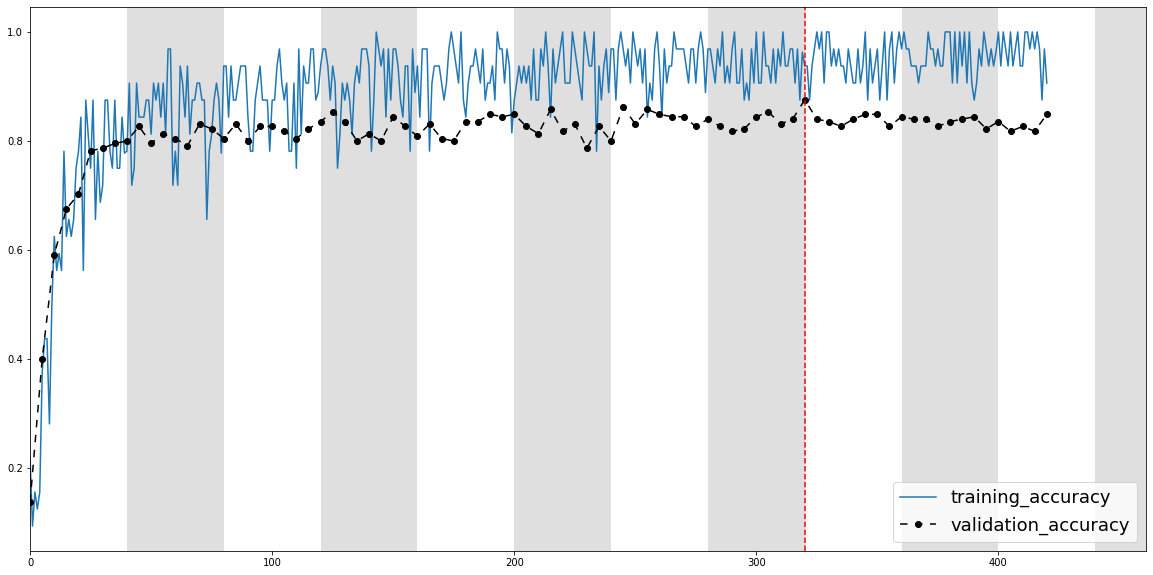

In [32]:
plot_results(tacc, vacc,'C0',True)

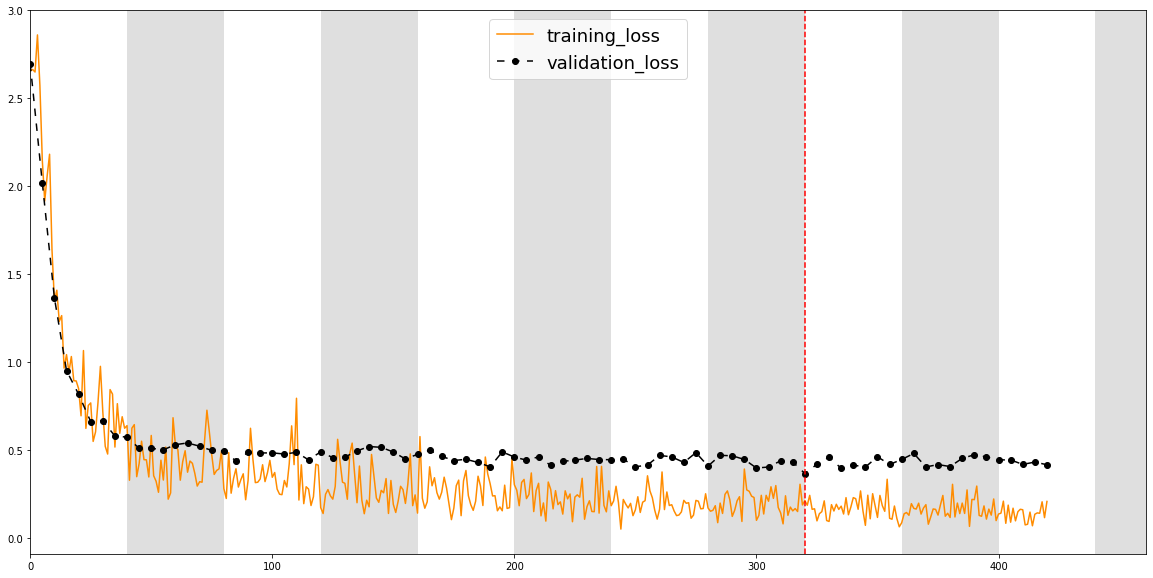

In [31]:
plot_results(tloss, vloss,'darkorange',False)

Test accuracy:  0.864321608040201


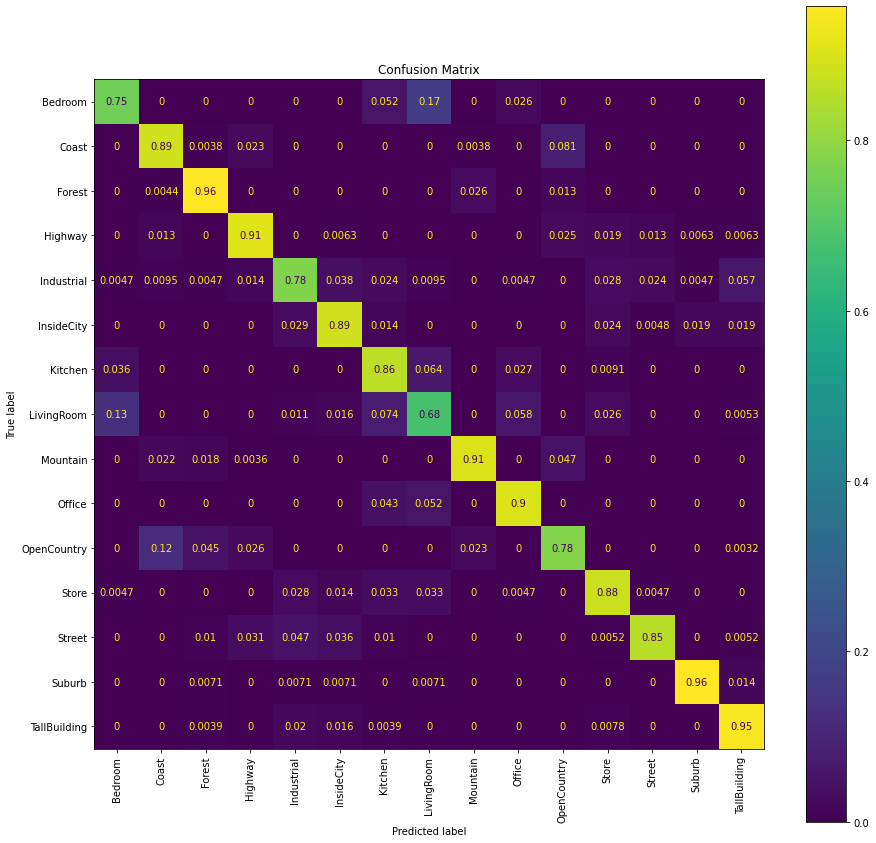

In [37]:
alexnet.load_state_dict(trained_net)
true_class, predicted_class = testing(alexnet,testLoader)
test_results(true_class,predicted_class)

#### 3.2 Multiclass SVM using CNN as feature extractor

In [9]:
# dictionary useful to build the dataset
classes = {1:'Bedroom',2:'Coast',3:'Forest',4:'Highway',5:'Industrial',6:'InsideCity',
               7:'Kitchen',8:'LivingRoom',9:'Mountain',10:'Office',11:'OpenCountry',
               12:'Store',13:'Street',14:'Suburb',15:'TallBuilding'}


alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

class feature_extractor(nn.Sequential):
    '''
    take just first part of alexnet to extract features
    '''
    def __init__(self):
        super(feature_extractor, self).__init__()

        self.features = alexnet.features
      
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


def preprocessing(img):
    img = img.convert(mode='RGB') # 3 channels
    t = transforms.Compose([transforms.Resize([224,224]),
                          transforms.ToTensor(), # also transforms in 0,1
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    i = t(img)
    return i

def load_images(rootPath,dictionary,transform,net):
    '''
    load all training set
    '''
    all_images = []
    all_labels = []
    for i in range(1,16):
        print('Loading class {}'.format(i))
        path = os.path.join(rootPath,dictionary[i])
        images = [transform(Image.open(os.path.join(path,filename)))for filename in os.listdir(path)]
        images = torch.stack((images))
        labels = np.ones(images.shape[0])*i
        net.eval()
        all_images.append(net(images).detach().numpy())
        all_labels.append(labels)
    return all_images, all_labels

def load_twoClasses(trainX,class1,class2):
    images = np.concatenate((trainX[class1-1],trainX[class2-1]),0)
    
    labels = np.concatenate((np.repeat(-1,trainX[class1-1].shape[0]),
                            np.repeat(1,trainX[class2-1].shape[0])))
    return images, labels

Using cache found in /home/claudia/.cache/torch/hub/pytorch_vision_v0.6.0


In [11]:
solvers.options['show_progress'] = False

def train_SVM(X,y,k,threshold,C):
    
    #K = np.matmul(X,X.T)
    K = k(X,X.T)
    y = y.reshape(-1,1) * 1.
    yyt = np.outer(y,y.T)
    H = np.multiply(yyt,K)*1.
    
    m,n = X.shape
    # now convert to cvxopt
    P = matrix(H) 
    q = matrix(-np.ones((m, 1)))
    G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    
    # now I can use these matrices to solve the optimization problem
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x'])
    #print(alphas)
    S = (alphas > threshold).flatten() # -6 if linear kernel, -9 polynomial2, -13poly3 

    sv_X = X[S,:]
    sv_Y = y[S]
    sv_Alphas = alphas[S]
        
    return [sv_X,sv_Y,sv_Alphas]

def decision_function(x,sv_X,sv_Y,sv_Alphas,k):
    coef = np.multiply(sv_Y,sv_Alphas).reshape(-1,1)
    kernel = k(x,sv_X.T)
    
    # now I need only b
    K= k(sv_X,sv_X.T)
    v = np.matmul(K,np.multiply(sv_Alphas,sv_Y))
    b = sv_Y-v
    avg_b = sum(b)/b.shape[0]
    val = np.matmul(kernel,coef) + avg_b
    
    val[val<0] = -1
    val[val>=0] = 1
    return val.flatten()

NameError: name 'trainX' is not defined

In [12]:
def train_all_SVM(class_list,train_data,kernel,C,threshold):
    '''
    Solves all pairwise svm optimizations, I also save number of sv
    '''    
    # here I store solutions and pairwise (training) accuracy 
    all_solutions = []
    sv_number = np.matrix(np.ones((len(class_list),len(class_list)))*1000)
    for i in range(1,len(class_list)+1):
        tmp_list = []
        for j in range(1,i):
            trainX, Y = load_twoClasses(train_data,i,j)
            #learn SVM 
            svX,svY,svA = train_SVM(trainX,Y,kernel,threshold,C)
            # save number of sv
            sv_number[i-1,j-1] = svX.shape[0]
            
            tmp_list.append([svX,svY,svA])
        all_solutions.append(tmp_list)
    return [all_solutions, sv_number]

def select_classes(class_list, sv_number_matrix):
    '''
    In each node select pair of classes with larger generalization capability= lower number of sv
    '''
    mask = np.matrix(np.ones((15,15))*100)# i'm looking for the min so I cannot put to 0
    for i in class_list:
        for j in class_list:
            mask[i-1,j-1] = 1
    val = np.matrix.argmin(np.multiply(sv_number_matrix,mask))
    i = int(val/sv_number_matrix.shape[0])+1
    j = val%sv_number_matrix.shape[0] +1
    return [i,j]

In [15]:
class node():
    #because of how I built A and dag class1>class2
    def __init__(self,class1,class2,test,left,right):
        self.left = left
        self.right = right
        self.class1 = class1
        self.class2 = class2
        self.test = test
        
    def evaluate(self,x,solutions,kernel):
        '''
        test the new image with the binary classifier of this node and call the evaluate 
        function of the right or left child
        '''
        result = test(x,self.class1,self.class2,solutions,kernel)
        if self.right==None and self.left==None:
            if result ==1:
                return self.class2
            else:
                return self.class1
        else:
            if result == 1:
                return self.right.evaluate(x,solutions,kernel)
            else:
                return self.left.evaluate(x,solutions,kernel)   

def build_dag(class_list,A):
    return recursive_step(class_list,A)

def recursive_step(class_list,A):
  # base case
  if len(class_list)==2:
    c1,c2 = select_classes(class_list,A)
    return node(c1,c2,test, None, None)
  else:
    # c1 is always greater than c2
    c1,c2 = select_classes(class_list,A)
    new_list1 = class_list.copy()
    new_list2 = class_list.copy()
    new_list1.remove(c1)
    new_list2.remove(c2)
    return node(c1,c2,test,recursive_step(new_list2,A),recursive_step(new_list1,A))

def test(x, c1, c2, solutions,kernel):
    svX,svY,svA = solutions[c1-1][c2-1]
    result = decision_function(x.reshape(1,-1),svX,svY,svA,kernel)
    return result

In [30]:
def test_multiclass(testLoader,solutions,dag,dictionary,net,kernel):
    true_class = []
    predictions = []
    for ii, data in enumerate(testLoader):
        image = data[0].float()
        label = data[1].tolist()
        label = [int(i)+1 for i in label]
        true_class= true_class+label

        features = net(image) .detach().numpy()
        pred = [dag.evaluate(features[ii,:].reshape(1,-1),solutions,kernel) for ii in range(features.shape[0])] 
        predictions = predictions + pred
        
        if ii%5==0:
            print('batch {}/{}'.format(ii,len(testLoader)))
        
    return [predictions, true_class]

def results(p,t,classes=classes):
    corr_class = [p[i]==t[i] for i in range(len(p))]
    acc = sum(corr_class)/len(corr_class)
    print('Test accuracy:',acc)

    conf_matrix = confusion_matrix(t, p)
    names = [classes[i] for i in range(1,16)]
    disp = ConfusionMatrixDisplay(conf_matrix, names)

    fig, ax = subplots(figsize=(15,15))
    ax.title.set_text('Confusion matrix')
    disp.plot(xticks_rotation='vertical',ax=ax)

In [29]:
net = feature_extractor()
trainX, trainY = load_images(trainPath,classes,preprocessing,net)

Loading class 1
Loading class 2
Loading class 3
Loading class 4
Loading class 5
Loading class 6
Loading class 7
Loading class 8
Loading class 9
Loading class 10
Loading class 11
Loading class 12
Loading class 13
Loading class 14
Loading class 15


#### Linear Kernel

In [31]:
testData = customDataset(testPath, preprocessing, augment=False)
testLoader = DataLoader(testData, batch_size = 32, shuffle=False, num_workers=1)

c = [i for i in range(1,16)] 
solutions, sv_number = train_all_SVM(c,trainX,linear_kernel,threshold = 1e-6,C=1)
dag = build_dag(c,sv_number)

In [32]:
p,t = test_multiclass(testLoader,solutions,dag,classes,net,linear_kernel)

batch 0/94
batch 5/94
batch 10/94
batch 15/94
batch 20/94
batch 25/94
batch 30/94
batch 35/94
batch 40/94
batch 45/94
batch 50/94
batch 55/94
batch 60/94
batch 65/94
batch 70/94
batch 75/94
batch 80/94
batch 85/94
batch 90/94


Test accuracy: 0.8730318257956449


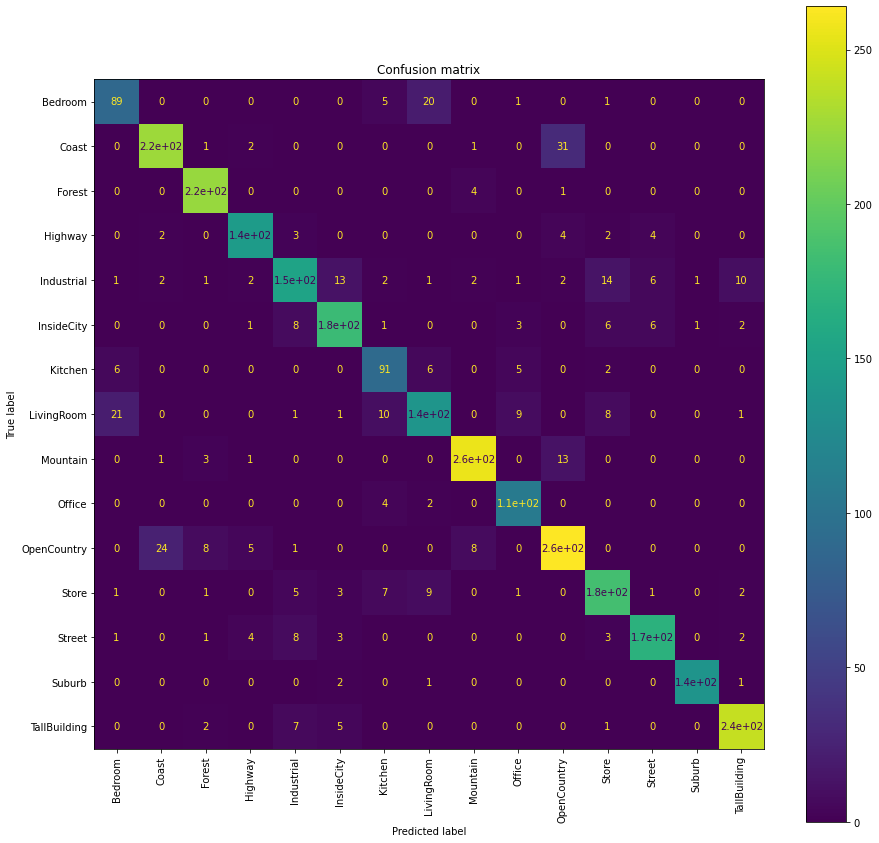

In [33]:
results(p,t)

#### Polynomial Kernel

In [23]:
# with degree 2  86% 1e-10 C=1
# with degree 3 83% 1e-13 C=20

def polynomial_kernel(x,y,d=3):
    return np.matmul(x,y)**d

solutions, sv_number = train_all_SVM(c,trainX,polynomial_kernel,C=20,threshold = 1e-13)
dag = build_dag(c,sv_number)

In [24]:
p,t = test_multiclass(testLoader,solutions,dag,classes,net,polynomial_kernel)

batch 0/94
batch 5/94
batch 10/94
batch 15/94
batch 20/94
batch 25/94
batch 30/94
batch 35/94
batch 40/94
batch 45/94
batch 50/94
batch 55/94
batch 60/94
batch 65/94
batch 70/94
batch 75/94
batch 80/94
batch 85/94
batch 90/94


Test accuracy: 0.8311557788944723


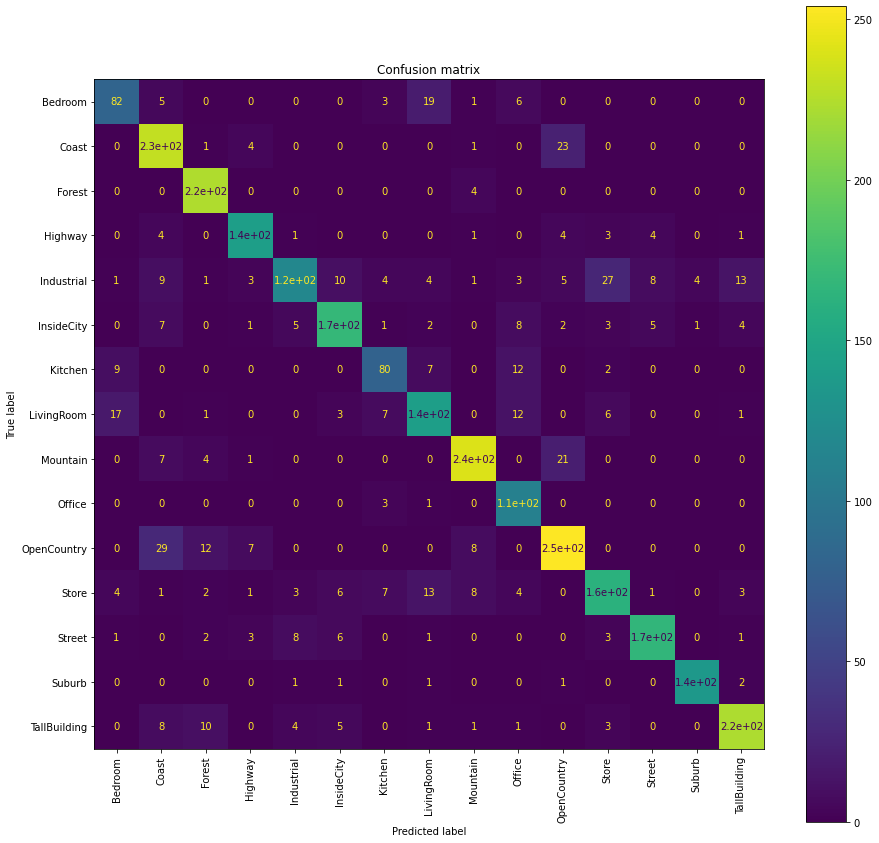

In [25]:
results(p,t)

#### Gaussian Kernel

In [26]:
#works but quite slow, to be faster use optimized function of sklearn
#It does the same exact computation
'''
def gaussian_kernel(x,y,c=1e+2): 
    n = np.zeros((x.shape[0],y.shape[1]),dtype=float)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            n[i][j] = gauss(x[i,:],y[:,j],c)
    return n
def gauss(x,y,c):
    return np.exp((-(np.linalg.norm(x-y)**2))/(c**2))
'''

def gaussian_kernel(x,y,c=5e+4):
    return sklearn.metrics.pairwise.rbf_kernel(x,y.T,1/c)

# 0.869 with C=1, t=0.4, c=5e+4
solutions, sv_number = train_all_SVM(c,trainX,gaussian_kernel,C=1,threshold = 0.4)
dag = build_dag(c,sv_number)

In [27]:
p,t = test_multiclass(testLoader,solutions,dag,classes,net,gaussian_kernel)

batch 0/94
batch 5/94
batch 10/94
batch 15/94
batch 20/94
batch 25/94
batch 30/94
batch 35/94
batch 40/94
batch 45/94
batch 50/94
batch 55/94
batch 60/94
batch 65/94
batch 70/94
batch 75/94
batch 80/94
batch 85/94
batch 90/94


Test accuracy: 0.8690117252931323


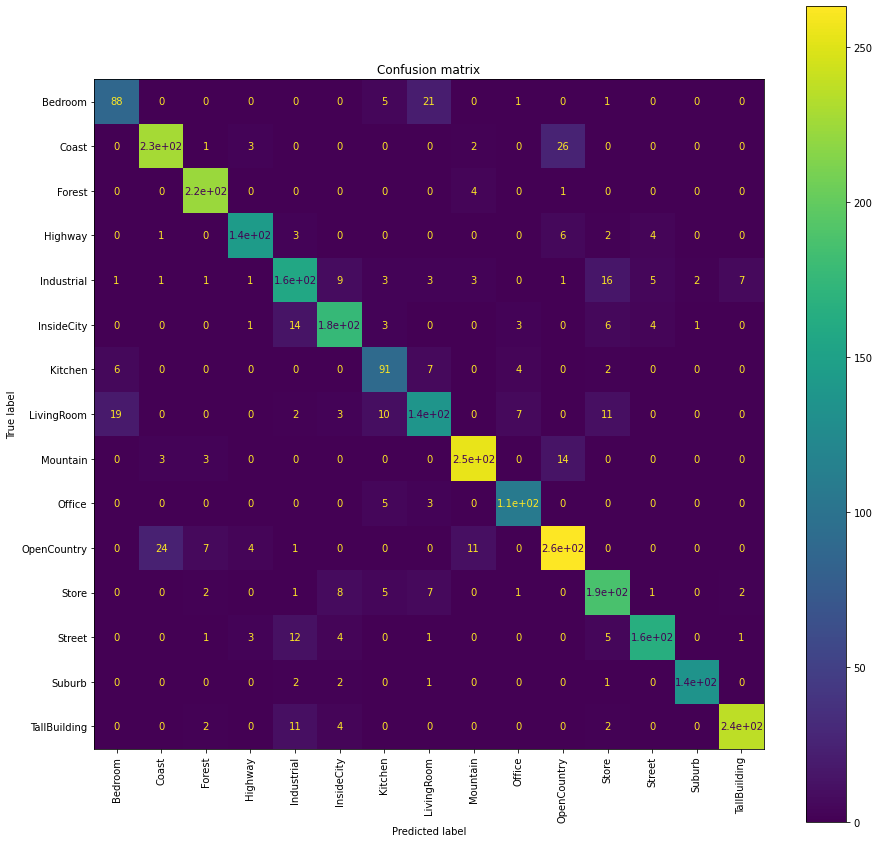

In [28]:
results(p,t)